# Image Reconstruction using One Fully connected layer

Here, I will investigate if we can use DL to reconstruct MNIST data that has been encoded with coded aperture.   
**Research Question:** Given a coded image, 
(1) can we recover/reconstruct the image, and
(2) can we recover the decoding pattern?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.fft import fft2, ifft2, fft, ifft

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from CNN import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [44]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Prepare MNIST Data

## Hyperparameters
Here, I will define hyperparameters for both the model and some needed for preprocessing.  

To define the MURA encoding and decoding, we first define a size $p$ for the MURA array and then use the encoder and decoding functions to create the encoder array $A$ and the decoder array $G$

In [5]:
# define hyperparameters
params = {
 # "dataset": "MNIST",
 # "machine": "desktop",
  "model": "NN",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 200,
}
wandb.config = params

# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

## Transform data
The MNIST data is originally defined as a tuple of (images, labels). We will redefine the tuple to be (encoded image, original image) for this reconstruction task. 
Both the encoded images and original images will be size $p \times p$. 

In [6]:
# Define the size of MNIST image to be equal to the size of A 
size = A.shape[0]

# Load MNIST data from PyTorch and do some transformations
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]) 
)

In [68]:
%%time
# ------------------ Create new set of training and testing 

# Define lists to save encoded image and original image data
mura_train_data = []
mura_test_data  = []

# Store training data
for idx in range(len(train_data)):
    img_label_list = list(train_data[idx])
    
    # Data will be saved as a tuple of (encoded image, original image) where we will use original image as labels
    img_label_list[0] = torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(train_data[idx][0].numpy()), A,size), dtype= torch.float), 0)
    img_label_list[1] = train_data[idx][0]
   
    mura_train_data.append(tuple(img_label_list))

# Store test data
for idx in range(len(test_data)):
    img_label_list = list(test_data[idx])
    
    # Data will be saved as a tuple of (encoded image, original image) where we will use original image as labels
    img_label_list[0] = torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(test_data[idx][0].numpy()), A,size), dtype= torch.float), 0)
    img_label_list[1] = test_data[idx][0]

    mura_test_data.append(tuple(img_label_list))

print("Done!")

Done!
CPU times: user 48.4 s, sys: 1.06 s, total: 49.5 s
Wall time: 50.2 s


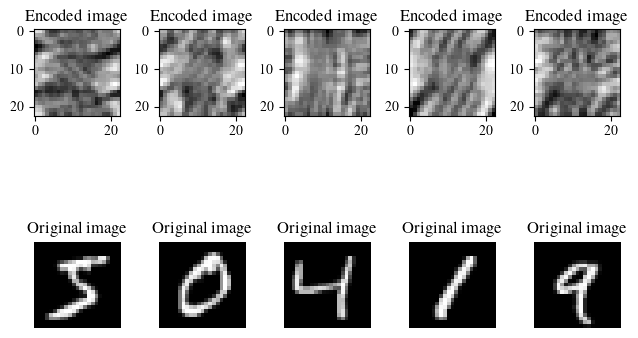

In [8]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
  
for idx in range(random_samples.shape[0]):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(mura_train_data[idx][0][0].numpy(), cmap='gray')
    plt.title('Encoded image')
    plt.subplot(2, 5, idx + 6)
    plt.imshow(mura_train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define data loaders with new data

In [9]:
loaders = {
    'train' : torch.utils.data.DataLoader(mura_train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(mura_test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

# Define Model

In [10]:
class NN(torch.nn.Module):
    '''
    Define a model with only one fully connected layer and no activation function
    '''
    def __init__(self, img_size):
        super().__init__()  
        self.img_size = img_size
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.img_size * self.img_size, self.img_size * self.img_size),
        )
    def forward(self, x):
        output = self.model(x)
        return output

In [11]:
# Instantiate model 
model = NN(size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate']) 
PATH = f'../models/NN_mnist_{params["epochs"]}epochs.pth'

# Training

In [40]:
torch.save(model.state_dict(), PATH)

# Evaluation

In [12]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

model.0.weight
model.0.bias


In [15]:
model.state_dict()['model.0.bias'].shape

torch.Size([529])

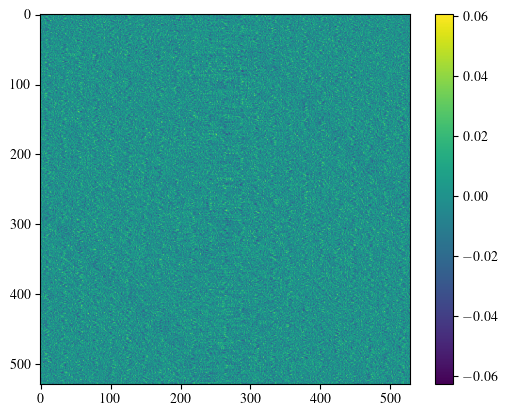

In [16]:
# Plot one dimension of weights
plt.imshow(model.state_dict()['model.0.weight'])
plt.colorbar()

# # plot bias
# plt.imshow(torch.reshape(model.state_dict()['model.0.bias'],(23,23)))
# plt.colorbar()

## Plot training loss

In [13]:
# Plotting the training loss
#plt.plot(range(1, params['epochs']+1), train_loss)
plt.plot(range(1, params["epochs"]+1), train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

NameError: name 'train_loss' is not defined

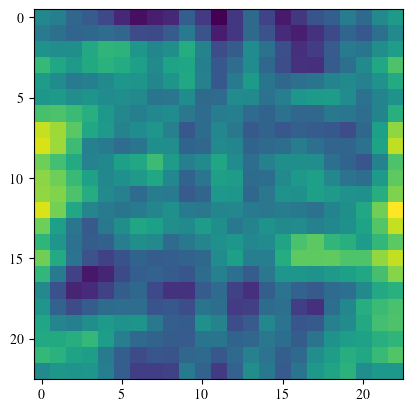

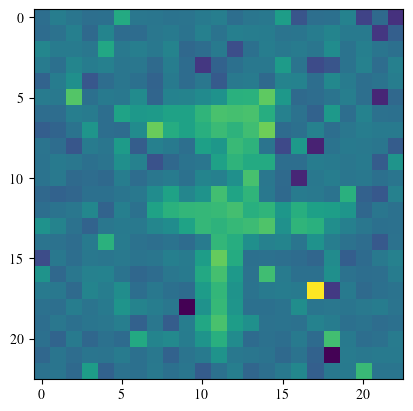

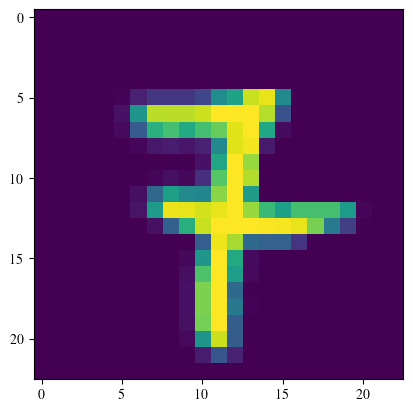

In [18]:
idx = 200
plt.imshow(torch.reshape(outputs[idx]['img'][10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['out'].detach()[10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['label'][10], (model.img_size, model.img_size))); plt.show()

# Code for test set evaluation that I need to modify

In [61]:
# Initialize variables
images_all = []
predicted_all = []
labels_all = []
mse_all = []
test_outputs = {}

with torch.no_grad():
    for data in loaders['test']:
        # get images and labels from test set
        img_batch, label_batch = data
        # Reshaping into 1d vector
        img_batch = img_batch.reshape(-1, model.img_size * model.img_size)
        label_batch = label_batch.reshape(params['batch_size'],model.img_size *model.img_size)
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction in zip(img_batch, label_batch, pred_batch):
            one_mse = sklearn.metrics.mean_squared_error(label, prediction)
            # Store values in lists
            mse_all.append(one_mse)
            images_all.append(image.reshape(-1, model.img_size, model.img_size))
            labels_all.append(label.reshape(-1, model.img_size, model.img_size))
            predicted_all.append(prediction.reshape(-1, model.img_size, model.img_size))
           
            
            
            
        # # Storing information in dictionary
        # test_outputs['img']       = img_batch.reshape(-1, model.img_size, model.img_size)
        # test_outputs['pred']      = pred_batch.reshape(-1, model.img_size, model.img_size)
        # test_outputs['label']     = label_batch.reshape(-1, model.img_size, model.img_size)
    # Storing information in dictionary
    test_outputs['img']       = images_all
    test_outputs['label']     = labels_all
    test_outputs['pred']      = predicted_all
    test_outputs['mse_score'] = mse_all

In [52]:
pd.Series(mse_all).describe()

count    10000.000000
mean         0.061068
std          0.039483
min          0.002345
25%          0.033087
50%          0.053249
75%          0.079502
max          0.330395
dtype: float64

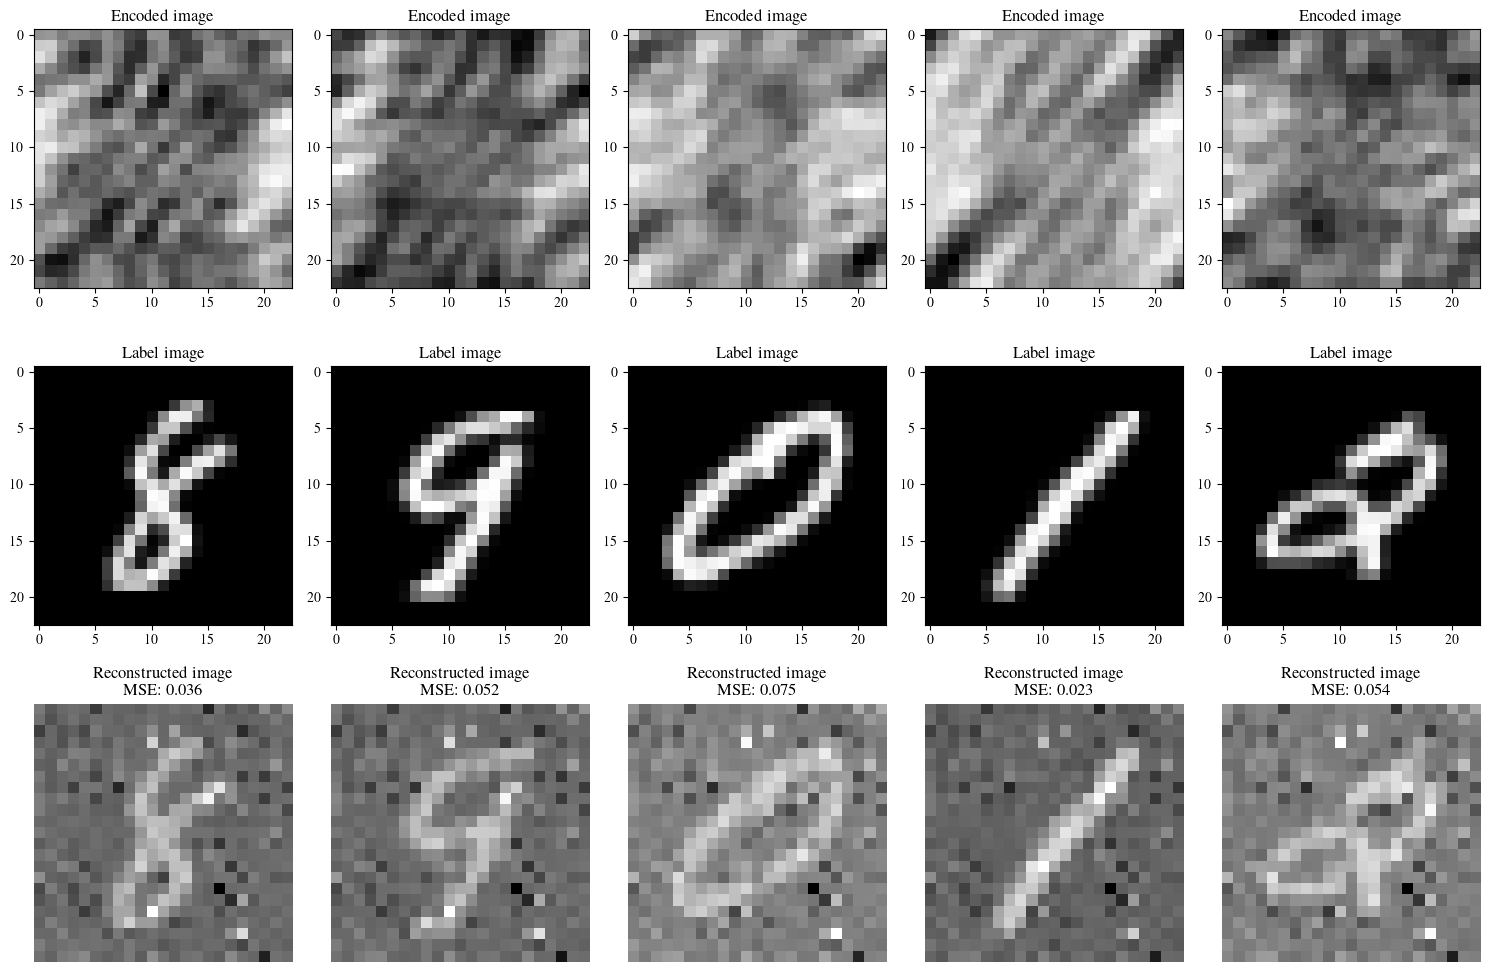

In [46]:
# Printing random images from the training dataset
random_samples = np.random.randint(1, len(loaders['test']), (5))
  
for idx in range(random_samples.shape[0]):
    # Plot encoded input image
    plt.subplot(3, 5, idx + 1)
    input_img = torch.reshape(img_batch[idx], (model.img_size,model.img_size))
    plt.imshow(input_img, cmap='gray')
    plt.title('Encoded image')
    
    # Plot original label image
    plt.subplot(3, 5, idx + 6)
    label_image = torch.reshape(label_batch[idx], (model.img_size,model.img_size))
    plt.imshow(label_image, cmap='gray')
    plt.title('Label image')
    
    # Plot reconstruction
    plt.subplot(3, 5, idx + 11)
    pred_image = torch.reshape(model(img_batch[idx]).detach(), (model.img_size,model.img_size))
    #pred_image = mura.normalize(pred_image.numpy())
    mse_recon = sklearn.metrics.mean_squared_error(label_image, pred_image)
    plt.imshow(pred_image, cmap='gray')
    plt.title(f'Reconstructed image \n MSE: {mse_recon: .3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

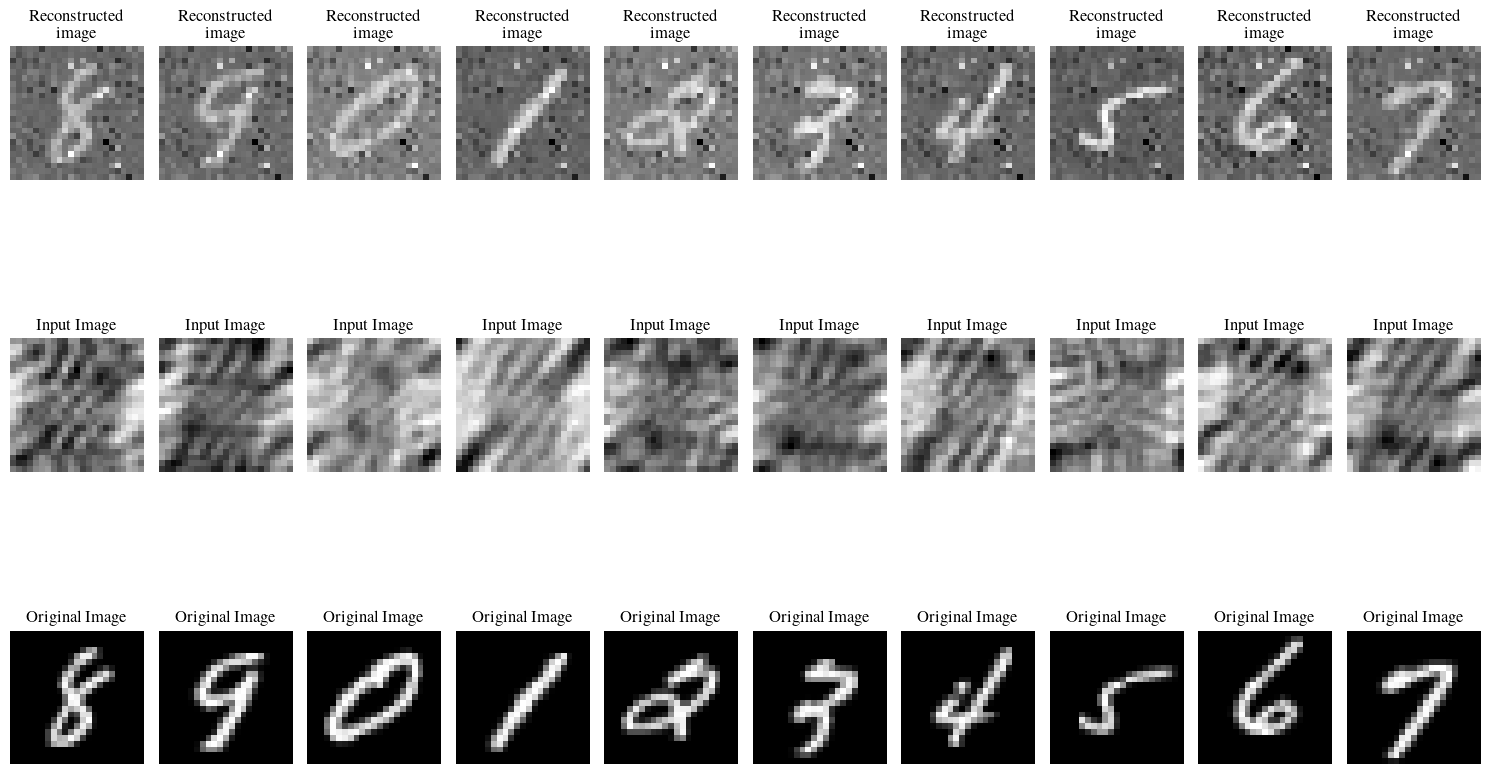

In [47]:
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = test_outputs['pred'].detach().numpy()
  
# Plotting first 10 images of the batch
for idx in range(10):
    plt.subplot(3, 10, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['img']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting label images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['label']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()

In [64]:
pd.DataFrame.from_dict(test_outputs)

,img,label,pred,mse_score
0,"[[[tensor(22.4346), tensor(20.2838), tensor(19...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.1027), tensor(-0.1293), tensor(-0....",0.024240
1,"[[[tensor(45.3832), tensor(46.1378), tensor(42...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.1652), tensor(-0.0629), tensor(0.0...",0.070032
2,"[[[tensor(11.1151), tensor(13.3269), tensor(13...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0678), tensor(-0.0469), tensor(-0....",0.007270
3,"[[[tensor(55.5481), tensor(51.7245), tensor(47...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.2204), tensor(-0.2626), tensor(-0....",0.101347
4,"[[[tensor(23.8692), tensor(24.2009), tensor(24...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0780), tensor(-0.1748), tensor(-0....",0.030316
...,...,...,...,...
9995,"[[[tensor(47.3305), tensor(48.8657), tensor(53...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.1813), tensor(-0.2379), tensor(0.0...",0.112506
9996,"[[[tensor(54.0187), tensor(57.2399), tensor(56...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.1767), tensor(-0.1800), tensor(-0....",0.086287
9997,"[[[tensor(31.8310), tensor(30.7788), tensor(32...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.1998), tensor(-0.1897), tensor(-0....",0.066763
9998,"[[[tensor(40.8308), tensor(36.8861), tensor(31...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0086), tensor(-0.0546), tensor(-0....",0.056982
